In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import torchtext
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import random
import pandas as pd

debug = False

print("Pytorch: \t\t", torch.__version__)
if not debug and torch.cuda.is_available():
    device='cuda'
    print('GPU:         \t\t', torch.cuda.get_device_name(0))
    print('Memory Usage:\t',
        round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB / ',
        round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'

Pytorch: 		 1.10.2+cu102
GPU is **not available**


In [2]:
# Initializing parameters

batch_size = 32     # Reduce this if you get memory errors

seed = 2476          # A random seed to get replicable results

sequence_max_length = 250

vocab_size = 10000

In [3]:
data_dir = pathlib.Path('/home/addy/datasets/aclImdb_v1/')

if data_dir.exists():
    print("Found the 'aclImdb_v1' dataset.")
else:
    print("Downloading the 'aclImdb_v1' dataset.")
    dataset_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    !wget {dataset_url} -P {data_dir.parent}
    !mkdir {data_dir}
    !tar xf {data_dir.parent / "aclImdb_v1.tar.gz"} -C {data_dir}
    !mv {data_dir / 'train' / 'unsup'} {data_dir / 'unsup'}
data_dir = data_dir / 'aclImdb'


Found the 'aclImdb_v1' dataset.


In [16]:
class DFDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        res = list(self.df.iloc[index])
        res.append(index)
        return res

    def add_new_df(self, new_df):
        self.df = self.df.append(new_df, ignore_index=True)

In [5]:
def cleanup(data):
    return data.replace('<br />', '')

test_dir = data_dir / 'test'

files = [y for y in (test_dir).glob('*/*')] 
random.shuffle(files)

num_test = len(files)//2
testdata = [(i.parent.stem, cleanup(open(i).read())) for i in files[:num_test]]

oracledata = [(i.parent.stem, cleanup(open(i).read())) for i in files[num_test:]]
oracledata += [(i.parent.stem, cleanup(open(i).read())) for i in files]

train_dir = data_dir / 'train'

files = [y for y in (train_dir).glob('*/*')] 

testdf = pd.DataFrame(testdata, columns =['cat', 'text'])
traindf = pd.DataFrame([], columns =['cat', 'text'])
oracledf = pd.DataFrame(oracledata, columns =['cat', 'text'])

print(len(traindf))
print()
print(tuple(testdf.iloc[0]))
print()
print(tuple(oracledf.iloc[0]))
print()
len(traindf), len(testdf), len(oracledf)

0

('pos', "Absolutely the most thoughtful, spiritually deep, intense Hamlet ever done -- no other version comes close. Jacobi has the best understanding of the role of all the actors that have played it. Patrick Stewart's Claudius is ferocious and still sympathetic -- I particularly like the two doofuses playing Rosencranz and Guildenstern. Very feckless and yet sinister. Some might gripe about the need for a strong Ophelia -- she's not a strong person, that's the point, and Lalla Ward hits the proper nuances. Amazing. Simply Amazing -- every one of the more than two dozen times I've watched it.")

('pos', "Am an ardent Vijay fan. I have never seen another movie of his which is as good as this.It has all the regular clichés that one can expect from a commercial entertainer. A hero who is bad in studies but a star in his forte i.e.Kabbadi. His friends to fill in the comedy quota. A heroine in a life-and-death situation. A villain, which I say is the best ever portrayed by the protagoni

(0, 12500, 37500)

In [17]:
train_dataset = DFDataset(traindf)
test_dataset = DFDataset(testdf)
oracle_dataset = DFDataset(oracledf)


In [18]:
from collections import Counter, OrderedDict

def build_vocab_from_iterator(iterator, min_freq: int = 1, specials = [], special_first: bool = True, vocab_size = None):
    counter = Counter()
    for tokens in iterator:
        counter.update(tokens)

    if specials is not None:
        for tok in specials:
            del counter[tok]

    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[0])
    sorted_by_freq_tuples.sort(key=lambda x: x[1], reverse=True)
    
    if vocab_size is not None:
        sorted_by_freq_tuples = sorted_by_freq_tuples[:vocab_size]

    ordered_dict = OrderedDict(sorted_by_freq_tuples)

    if specials is not None:
        if special_first:
            specials = specials[::-1]
        for symbol in specials:
            ordered_dict.update({symbol: min_freq})
            ordered_dict.move_to_end(symbol, last=not special_first)

    word_vocab = torchtext.vocab.vocab(ordered_dict, min_freq=min_freq)
    return word_vocab


In [19]:
'''
Each query strategy below returns a list of len=query_size with indices of 
samples that are to be queried.

Arguments:
- model (torch.nn.Module): not needed for `random_query`
- device (torch.device): not needed for `random_query`
- dataloader (torch.utils.data.DataLoader)
- query_size (int): number of samples to be queried for labels (default=10)

'''
def random_query(data_loader, query_size=10):
    
    sample_idx = []
    
    # Because the data has already been shuffled inside the data loader,
    # we can simply return the `query_size` first samples from it
    for batch in data_loader:
        
        _, _, idx = batch
        sample_idx.extend(idx.tolist())

        if len(sample_idx) >= query_size:
            break
    
    return sample_idx[0:query_size]

def binary_least_confidence_query(model, device, data_loader, query_size=10):

    confidences = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Keep only the top class confidence for each sample
            most_probable = torch.max(probabilities, dim=1)[0]
            confidences.extend(most_probable.cpu().tolist())
            indices.extend(idx.tolist())
            
    conf = np.asarray(confidences)
    ind = np.asarray(indices)
    sorted_pool = np.argsort(conf)
    # Return the indices corresponding to the lowest `query_size` confidences
    return ind[sorted_pool][0:query_size]

def least_confidence_query(model, device, data_loader, query_size=10):

    confidences = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Keep only the top class confidence for each sample
            most_probable = torch.max(probabilities, dim=1)[0]
            confidences.extend(most_probable.cpu().tolist())
            indices.extend(idx.tolist())
            
    conf = np.asarray(confidences)
    ind = np.asarray(indices)
    sorted_pool = np.argsort(conf)
    # Return the indices corresponding to the lowest `query_size` confidences
    return ind[sorted_pool][0:query_size]

def margin_query(model, device, data_loader, query_size=10):
    
    margins = []
    indices = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in data_loader:
        
            data, _, idx = batch
            logits = model(data.to(device))
            probabilities = F.softmax(logits, dim=1)
            
            # Select the top two class confidences for each sample
            toptwo = torch.topk(probabilities, 2, dim=1)[0]
            
            # Compute the margins = differences between the two top confidences
            differences = toptwo[:,0]-toptwo[:,1]
            margins.extend(torch.abs(differences).cpu().tolist())
            indices.extend(idx.tolist())

    margin = np.asarray(margins)
    index = np.asarray(indices)
    sorted_pool = np.argsort(margin)
    # Return the indices corresponding to the lowest `query_size` margins
    return index[sorted_pool][0:query_size]


In [20]:
def query_the_oracle(model, device, dataset, query_size=10, query_strategy='random', 
                     interactive=False, pool_size=0, num_workers=4):
    if pool_size > 0:    
        sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=pool_size)
        pool_loader = DataLoader(dataset, sampler=sampler, batch_size=batch_size, num_workers=num_workers)
    else:
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        
    if query_strategy == 'margin':
        sample_idx = margin_query(model, device, pool_loader, query_size)
    elif query_strategy == 'least_confidence':
        sample_idx = least_confidence_query(model, device, pool_loader, query_size)
    else:
        sample_idx = random_query(pool_loader, query_size)

    # Query the samples, one at a time
    # for sample in sample_idx:
    #     if interactive:
            # dataset.display(sample)
            # print("What is the class of this image?")
            # new_label = int(input())
            # dataset.update_label(sample, new_label)

    res = dataset.df.iloc[sample_idx]
    dataset.df.drop(dataset.df.iloc[sample_idx].index, inplace=True)
    return res

def query_the_binary_oracle(model, device, dataset, query_size=10, query_strategy='random', 
                     interactive=False, pool_size=0, num_workers=4):
    if pool_size > 0:    
        sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=pool_size)
        pool_loader = DataLoader(dataset, sampler=sampler, batch_size=batch_size, num_workers=num_workers)
    else:
        pool_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        
    if query_strategy == 'least_confidence':
        sample_idx = binary_least_confidence_query(model, device, pool_loader, query_size)
    if query_strategy == 'split':
        half = query_size//2
        sample_idx = binary_least_confidence_query(model, device, pool_loader, half)
        sample_idx += random_query(pool_loader, query_size, query_size - half)
    else:
        sample_idx = random_query(pool_loader, query_size)

    # Query the samples, one at a time
    # for sample in sample_idx:
    #     if interactive:
            # dataset.display(sample)
            # print("What is the class of this image?")
            # new_label = int(input())
            # dataset.update_label(sample, new_label)

    res = dataset.df.iloc[sample_idx]
    dataset.df.drop(dataset.df.iloc[sample_idx].index, inplace=True)
    return res

In [21]:
splits = {
    0: 12500
}

new_datapoints = query_the_binary_oracle(None, device, oracle_dataset, splits[0])
train_dataset.add_new_df(new_datapoints)

In [22]:
len(train_dataset.df)

12500

In [23]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text, _ in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<pad>", "<unk>"], vocab_size=10000-2)
vocab.set_default_index(vocab["<unk>"])

pad_id = vocab['<pad>']

In [24]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == 'pos' else 0

In [25]:
pad_id, len(vocab)

(0, 10000)

## Avoiding ValueError (using a target size different to the input size)

```ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.```

Simply add `.unsqueeze(-1)` to the end of your label tensor.



In [26]:
def collate_batch(batch):
     label_list, text_list, idx_list = [], [], []
     for (label, text, idx) in batch:
          input = text_pipeline(text)
          label_list.append(torch.tensor([label_pipeline(label)], dtype=torch.float32))
          
          a = torch.tensor(input[:sequence_max_length], dtype=torch.int64)
          b = torch.zeros(max(0, sequence_max_length - len(input)), dtype=torch.int64)
          text_list.append(torch.cat((a,b)))

          idx_list.append(idx)
               
     label_list = torch.stack(label_list)
     text_list = torch.stack(text_list)
     return text_list, label_list, idx_list

In [27]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    num_workers=8,
    batch_size=batch_size,
    collate_fn=collate_batch)

test_dataloader = DataLoader(
    test_dataset, 
    num_workers=8,
    batch_size=batch_size, 
    collate_fn=collate_batch)


In [28]:

for X, y, _ in train_dataloader:
    print("Shape of X: ", X.shape)
    print("Labels : ", y.shape)
    print("SAMPLE")
    print("Label: ",y[0].item())
    print("Text:")
    print(" ".join(vocab.lookup_tokens(X[0].tolist())))
    # print(X, y, o)
    break

Shape of X:  torch.Size([32, 250])
Labels :  torch.Size([32, 1])
SAMPLE
Label:  1.0
Text:
this is one of the best films made about the 80 punk scene . i saw this a few years back on a <unk> copy and was amazed . very few of todays kids know the true roots of punk and this movie shows some of the 80s punk legends such as the <unk> and shows how it was back then . nowadays so much punk has gone mainstream with mtv and radio and its nice to see the true underground rebellious movement of the original scene . <unk> crash ( of the <unk> ) is one of my <unk> and this film shows why . a must see for all punks and anyone curious about the 80s punk scene <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

In [29]:
from torch import nn

class ClassifyNet(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        # self.pool = nn.AvgPool1d(3, stride=2)
        self.fc = nn.Linear(embed_dim, num_class)
        self.dropout = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.emb(x)
        # print(x.shape)
        x = self.dropout(x)
        x = torch.mean(x, 1)
        x = self.dropout2(x)
        # print(x.shape)
        x = self.fc(x)

        return torch.sigmoid(x)

In [30]:
a = torch.randn(32, 250, 16)
torch.mean(a, 1).shape

torch.Size([32, 16])

In [31]:
def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader.dataset)
    total_loss, accuracy = 0, 0
    for batch, (X, y, _) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        #FORWARD PASS
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= size
    total_loss /= size
    history['train_loss'].append(total_loss)
    history['train_accuracy'].append(accuracy)
    return loss, accuracy


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        for X, y, _ in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            loss += loss_fn(pred, y).item()
            accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size

    history['test_loss'].append(loss)
    history['test_accuracy'].append(accuracy)
    return loss, accuracy

In [36]:
emsize = 16
num_classes = 1
vocab_size = len(vocab)

model = ClassifyNet(vocab_size, emsize, num_classes).to(device)
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)



In [37]:
count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {count}")

Number of trainable parameters: 160017


In [38]:
epochs = 30
history = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
    # if t % 4 == 3:
    #     new_datapoints = query_the_oracle(model, device, oracle_dataset, 10)
    #     train_dataset.add_new_df(new_datapoints)
    #     train_dataloader = DataLoader(
    #         train_dataset,
    #         shuffle=True,
    #         num_workers=8,
    #         batch_size=batch_size,
    #         collate_fn=collate_batch)
            
    train_loop(train_dataloader, model, loss_fn, optimizer, history)
    test_loop(test_dataloader, model, loss_fn, history)

01:06 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  2.22s/epoch]


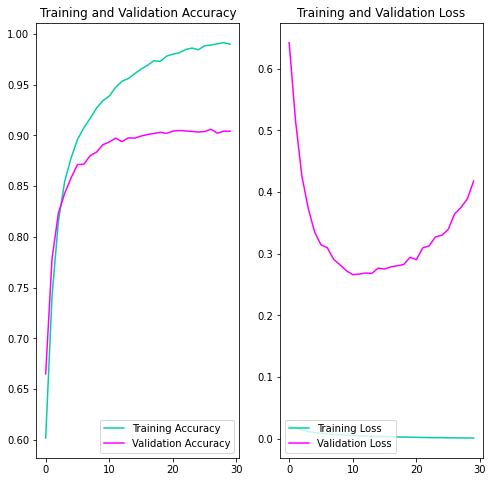

In [39]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='#03CEA4')
plt.plot(epochs_range, history['test_accuracy'], label='Validation Accuracy', color='#fc00ff')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='#03CEA4')
plt.plot(epochs_range, history['test_loss'], label='Validation Loss', color='#fc00ff')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()
